<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Chicago

By Amira, Joshua, Joseph, Nelson, Zhi Hong (DSI-28)

---
# Problem Statement

We are a team of data scientists at the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering. 

Due to the recent epidemic of West Nile Virus in the Windy City, the Department of Public Health set up a mosquito surveillance and control system. We are tasked to build a model that predicts the detection of the virus in various parts of the city and to derive an effective plan to deploy pesticides throughout the city.

---
# Structure

To organise our work better, we have organised this project into two notebooks: 

* Notebook 1 : Data Cleaning & Exploratory Data Analysis
* Notebook 2 : Feature Engineering, Modelling & Model Evaluation

<span style='color:red'>**This is Notebook 1.**</span>

# Data Cleaning & Exploratory Data Analysis

In [1]:
# import required libraries/packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import radians, sin, cos, sqrt, asin

import os
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

In [2]:
# load kaggle datasets
# to replace missing_values in weather dataset denoted as empty string or '-' with NaN

missing_values=[' ','-']
train_c = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
weather = pd.read_csv('data/weather.csv', na_values=missing_values)
spray = pd.read_csv('data/spray.csv')

# create a copy of train, so that train_c original structure will be retained
train = train_c.copy()

In [3]:
train.tail(1)

Date                                        Address  \
10505  2013-09-26  4200 West 65th Street, Chicago, IL 60621, USA   

                      Species  Block      Street  Trap  \
10505  CULEX PIPIENS/RESTUANS     42   W 65TH ST  T235   

             AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
10505  4200  W 65TH ST, Chicago, IL  41.776428 -87.627096                8   

       NumMosquitos  WnvPresent  
10505             1           0

In [4]:
test.tail(1)

Id        Date                                          Address  \
116292  116293  2014-10-02  2100 North Cannon Drive, Chicago, IL 60614, USA   

                Species  Block        Street   Trap  \
116292  CULEX ERRATICUS     21   N CANNON DR  T054C   

                AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  
116292  2100  N CANNON DR, Chicago, IL  41.925652  -87.63359                8

In [5]:
spray.tail(1)

Date        Time   Latitude  Longitude
14834  2013-09-05  8:35:41 PM  42.004805  -87.81746

In [6]:
weather.tail(1)

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
2943        2  2014-10-31    49    34   42      M        29      36   23    0   

      ...   CodeSum  Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
2943  ...  RA SN BR      M      M        M        0.04       29.54    30.20   

     ResultSpeed ResultDir  AvgSpeed  
2943        21.7        34      22.6  

[1 rows x 22 columns]

In [7]:
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')
print(f'spray shape: {spray.shape}')
print(f'weather shape: {weather.shape}')

train shape: (10506, 12)
test shape: (116293, 11)
spray shape: (14835, 4)
weather shape: (2944, 22)


In [8]:
# to adjust the format of 'date' to datetime format

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
weather['Date']= pd.to_datetime(weather['Date'])
spray['Date']= pd.to_datetime(spray['Date'])

## Train & Test Data

**Summary**
1. Train set contains data from 2007, 2009, 2011 and 2013 i.e. 2 years interval. 
2. Test set contains data from 2008, 2010, 2012, and 2014.

|Feature|Description|
|-:-|:-|
|Id | The id of the record |
|Date | Date that the WNV test is performed |
|Address | Approximate address of the location of trap. This is used to send to the GeoCoder. |
|Species| The species of mosquitos|
|Block| Block number of address|
|Street|Street name|
|Trap| Id of the trap|
|AddressNumberAndStreet|Approximate address returned from GeoCoder|
|Latitude, Longitude| Latitude and Longitude returned from GeoCoder|
|AddressAccuracy| Accuracy returned from GeoCoder|
|NumMosquitos| Number of mosquitoes caught in this trap|
|WnvPresent| Whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.|

**Decisions:**

* Test set does not have NumMosquitos column, while train set has. Therefore, NumMosquitos column will be retained for EDA segment, and subsequently dropped from the train set prior to the modelling stage. 
* Id column will be retained in test set as this is necessary for Kaggle submission.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [11]:
train.describe().T

count       mean        std        min        25%  \
Block            10506.0  35.687797  24.339468  10.000000  12.000000   
Latitude         10506.0  41.841139   0.112742  41.644612  41.732984   
Longitude        10506.0 -87.699908   0.096514 -87.930995 -87.760070   
AddressAccuracy  10506.0   7.819532   1.452921   3.000000   8.000000   
NumMosquitos     10506.0  12.853512  16.133816   1.000000   2.000000   
WnvPresent       10506.0   0.052446   0.222936   0.000000   0.000000   

                       50%        75%        max  
Block            33.000000  52.000000  98.000000  
Latitude         41.846283  41.954690  42.017430  
Longitude       -87.694991 -87.627796 -87.531635  
AddressAccuracy   8.000000   9.000000   9.000000  
NumMosquitos      5.000000  17.000000  50.000000  
WnvPresent        0.000000   0.000000   1.000000

In [12]:
test.describe().T

count          mean           std        min  \
Id               116293.0  58147.000000  33571.041765   1.000000   
Block            116293.0     41.131100     24.864726  10.000000   
Latitude         116293.0     41.849389      0.106593  41.644612   
Longitude        116293.0    -87.693658      0.080699 -87.930995   
AddressAccuracy  116293.0      7.954357      1.252733   3.000000   

                          25%           50%           75%            max  
Id               29074.000000  58147.000000  87220.000000  116293.000000  
Block               18.000000     39.000000     61.000000      98.000000  
Latitude            41.753411     41.862292     41.951866      42.017430  
Longitude          -87.750938    -87.694991    -87.648860     -87.531635  
AddressAccuracy      8.000000      8.000000      9.000000       9.000000

In [13]:
# these columns are available in both train and test sets 
# train set has WnvPresent and NumMosquitos columns which are not available in test set
# test set has Id column which is not available in train set

set(train.columns).intersection(set(test.columns))

{'Address',
 'AddressAccuracy',
 'AddressNumberAndStreet',
 'Block',
 'Date',
 'Latitude',
 'Longitude',
 'Species',
 'Street',
 'Trap'}

### No Missing Data in Train and Test Sets

In [14]:
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [15]:
test.isnull().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

### Examining Address-related Features

* Address column seems to be a concatenated version of Block, Street, City, State, Postal Code and Country.
* AddressNumberandStreet column seems to be a shorter version consisting of only Block, Street, City and State.
* It seems that the Block column are two-digit values but get converted to four-digit values in Address and AddressNumberandStreet columns.
* **Decision:** Since we have the Latitude/Longitude data, we will **not use the Address, Block, Street and AddressNumberandStreet features**.

In [16]:
train[['Address','Block','Street','AddressNumberAndStreet']].tail(2)

Address  Block         Street  \
10504  7100 North Harlem Avenue, Chicago, IL 60631, USA     71   N HARLEM AVE   
10505     4200 West 65th Street, Chicago, IL 60621, USA     42      W 65TH ST   

                AddressNumberAndStreet  
10504  7100  N HARLEM AVE, Chicago, IL  
10505     4200  W 65TH ST, Chicago, IL

In [17]:
test[['Address','Block','Street','AddressNumberAndStreet']].tail(2)

Address  Block        Street  \
116291  2100 North Cannon Drive, Chicago, IL 60614, USA     21   N CANNON DR   
116292  2100 North Cannon Drive, Chicago, IL 60614, USA     21   N CANNON DR   

                AddressNumberAndStreet  
116291  2100  N CANNON DR, Chicago, IL  
116292  2100  N CANNON DR, Chicago, IL

* AddressAccuracy is an output of the GeoCoder which tells us the accuracy of the derived location i.e. AddressNumberAndStreet, Lat/Long from the given datapoint i.e. Address. 
* While most of the data had AddressAccuracy >=5, a handful had AddressAccuracy == 3. Upon closer inspection, we find that the address is vague i.e. Chicago,IL,USA referring to the entire city. 
* **Decision:** Observations with AddressAccuracy == 3 will not be useful for our prediction models because the inputted data is vague. However, such observations can also be found in the test set and we note that we will have to submit the same number of rows for Kaggle submission. Moreover, only 0.8% of the train set and 0.6% of the test set are affected. Therefore, we will **not take any action on these observations**.  

In [18]:
train['AddressAccuracy'].value_counts()

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

In [19]:
test['AddressAccuracy'].value_counts()

8    61973
9    39795
5    13761
3      764
Name: AddressAccuracy, dtype: int64

In [20]:
train[train['AddressAccuracy'] == 3].tail(2)

Date           Address        Species  Block  \
10326 2013-09-19  Chicago, IL, USA  CULEX PIPIENS     43   
10433 2013-09-26  Chicago, IL, USA  CULEX PIPIENS     43   

                        Street  Trap  \
10326   N ASHLAND AVE OVERPASS  T145   
10433   N ASHLAND AVE OVERPASS  T145   

                          AddressNumberAndStreet   Latitude  Longitude  \
10326  4300  N ASHLAND AVE OVERPASS, Chicago, IL  41.878114 -87.629798   
10433  4300  N ASHLAND AVE OVERPASS, Chicago, IL  41.878114 -87.629798   

       AddressAccuracy  NumMosquitos  WnvPresent  
10326                3             9           0  
10433                3             2           0

In [21]:
test[test['AddressAccuracy'] == 3].tail(2)

Id       Date           Address            Species  Block  \
115347  115348 2014-10-02  Chicago, IL, USA  UNSPECIFIED CULEX     43   
115348  115349 2014-10-02  Chicago, IL, USA    CULEX ERRATICUS     43   

                         Street  Trap  \
115347   N ASHLAND AVE OVERPASS  T145   
115348   N ASHLAND AVE OVERPASS  T145   

                           AddressNumberAndStreet   Latitude  Longitude  \
115347  4300  N ASHLAND AVE OVERPASS, Chicago, IL  41.878114 -87.629798   
115348  4300  N ASHLAND AVE OVERPASS, Chicago, IL  41.878114 -87.629798   

        AddressAccuracy  
115347                3  
115348                3

### Managing Multiple Rows in Train Set Due to Max Value of 50 in NumMosquitos

* Data in train set are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
* **Decision:** to group train set based on Date, Species, Trap, Lat, Long, and reassign WnvPresent values (1 if virus is present, 0 if not).

In [22]:
# to exclude 'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy' from groupby
# this will effectively drop the columns in test set

train = train.groupby(['Date','Species','Trap','Latitude','Longitude'])[['WnvPresent','NumMosquitos']].agg('sum').reset_index()
train['WnvPresent'] = train['WnvPresent'].apply(lambda x: 1 if x >= 1 else 0)

In [23]:
train['WnvPresent'].value_counts()

0    8018
1     457
Name: WnvPresent, dtype: int64

In [24]:
# drop unnecessary address columns test sets

test = test.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis =1)

## Spray Data

**Summary**

1. The spray data contains info from the years 2011 and 2013, indicating the date, time and location of each spray. 
2. It is noted that spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
3. However, the information in the spray data is scanty and does not cover the years in the test set. 

**Decision:**
* Spray data will be explored at EDA, but will be excluded from the modelling stage.

In [25]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [26]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [27]:
# to adjust the format of date and time

spray['Time'] = pd.to_datetime(spray['Time'],format='%H:%M:%S %p')
spray['Time'] = spray['Time'].dt.time

In [28]:
# missing values seems to appear on the same day i.e. 7 Sep 2011

spray[spray['Time'].isna()]

Date Time   Latitude  Longitude
1030 2011-09-07  NaN  41.987092 -87.794286
1031 2011-09-07  NaN  41.987620 -87.794382
1032 2011-09-07  NaN  41.988004 -87.794574
1033 2011-09-07  NaN  41.988292 -87.795486
1034 2011-09-07  NaN  41.988100 -87.796014
...         ...  ...        ...        ...
1609 2011-09-07  NaN  41.995876 -87.811615
1610 2011-09-07  NaN  41.995972 -87.810271
1611 2011-09-07  NaN  41.995684 -87.810319
1612 2011-09-07  NaN  41.994724 -87.810415
1613 2011-09-07  NaN  41.993092 -87.810415

[584 rows x 4 columns]

In [29]:
# average_time on 7 Sep 2011 is '20:19:48'

spray['Time'].fillna('20:19:48', inplace = True)

<AxesSubplot:title={'center':'No. of sprays per date'}, ylabel='Date'>

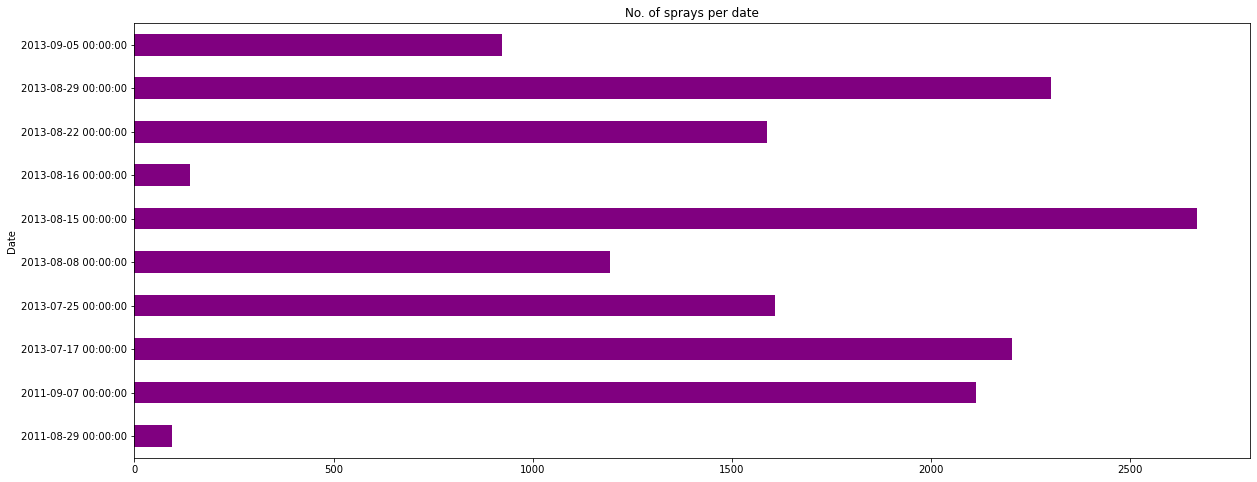

In [30]:
# group by date and plot no of sprays

spray = spray.sort_values(by=['Date'],ascending=False)
sprays = spray.groupby(['Date']).size()
sprays.plot.barh(color='purple',figsize=(20,8), title ='No. of sprays per date')

> **Interpretation:**
> * The spray data captures information across only 10 unique days in the years 2011 and 2013.
> * The frequency of sprays ranges from >2500 sprays in a single day to < 100. 
> * This dataset is incomplete and is a poor representation of actual sprays that took place over the years.

## Weather Data

**Summary** 
1. The weather data contains weather information observed between 2007 to 2014.
2. There were alot of missing values in certain columns as shown in the missing value chart
3. For the missing data, we took a step further and investigated the respective columns to determine the relationship/calulation for a more accruate outcome 
    - Classifying the respective Latitude and Longitude from train dataset and classify it according to station 1 or 2. 
    - Heat/Cool values is the difference between Tavg and base score (65 degree)
    - Researching and concluding that 'Trace' indicates the amount of rain that is less than 0.01 inch.

|Feature|Description|
|-:-|:-|
|Date | Date where weather situation is observed |
|Tmax | The highest temperature recorded for the day |
|Tmin | The lowest temperature recorded for the day |
|Tavg | The average temperature recorded for the day (Max, Min average) |
|Depart |Temperature departure from the normal that indicates if the dekadal average temperatures were above/below the 30 year normal|
|Dewpoint|Temperature the air needs to be cooled at in order to achieve a relative humidty of 100% (moisture in the air)|
|WetBulb| Lowest temperature to which air can be cooled by the evaporation of water into the air|
|Heat & Cool| How far the average temperature is from the base (65 degress)|
|Sunrise| Calculated time of the sunrise at the respective stations|
|Sunset| Calculated time of the sunset at the respective stations|
|CodeSum|The weather phenomena observated at the respective stations|
|Depth|The Snow/Ice depth on the ground|
|Water1|Water Equivalent of snow/ice on ground|
|Snowfall|Snowfall measured in inches and tenths at the respective stations|
|PrecipTotal| The total precipitation of rainfall/melted snow 
|StnPressure|The average barometric pressure that is observed at specific elevation|
|SeaLevel|The atmospheric pressure at mean sea level|
|ResultSpeed|Speed in miles per hour|
|ResultDir|Resultant wind speed|
|AvgSpeed|Average wind speed|


## Assigning closest weather station to each observation in train/test data

In [31]:
#Nearest Neighbour analysis with Haversine Distance

def dist(lat1, lon1, lat2, lon2): 
    R = 6371
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.power(np.sin(dLat/2), 2) + np.multiply(np.cos(lat1), np.multiply(np.cos(lat2), np.power(np.sin(dLon/2), 2)))
    c = 2*np.arcsin(np.sqrt(a))
    km = R * c
    return km

def station1or2(df):
    df['lat1']=41.995  
    df['lat2']=41.786   
    df['lon1']=-87.933  
    df['lon2']=-87.752  
    df['dist1'] = dist(df.Latitude.values, df.Longitude.values, df.lat1.values, df.lon1.values) 
    df['dist2'] = dist(df.Latitude.values, df.Longitude.values, df.lat2.values, df.lon2.values)
    indicator = np.less_equal(df.dist1.values, df.dist2.values) 
    df_station = np.ones(df.shape[0])
    df_station[indicator==0]=2
    df['Station']=df_station     
    df.drop(['dist1', 'dist2', 'lat1', 'lat2', 'lon1', 'lon2' ], axis=1, inplace=True)
    return df

train = station1or2(train)
test = station1or2(test)

## Managing Missing Values in Weather Data

**These are the steps taken:**

1. Replaced 'M' with None such that all missing values are correctly reflected. Previously, when importing datasets we had also set empty strings and '-' to None. 
2. Dropped columns that had large no. of missing values: 'Depart', 'Depth', 'SnowFall', 'Water1', 'CodeSum'
3. Several methods were adopted to impute remaining missing values: 
  * Forward Fill of values for Sunrise, Sunset, AvgSpeed and PrecipitationTotal
  * Backward Fill of values for WetBulb
  * Imputed missing Average Temperature with mean of Max Temperature and Min Temperature
  * Imputed missing SeaLevel and Station Pressure values with mean values
  * Imputed missing Heat/Cool values with difference from 65F
4. Merged clean weather data with train/test data using Date and Station No. as key identifiers.
  

In [32]:
# replace 'M' with np.nan

weather = weather.replace({"M": None})

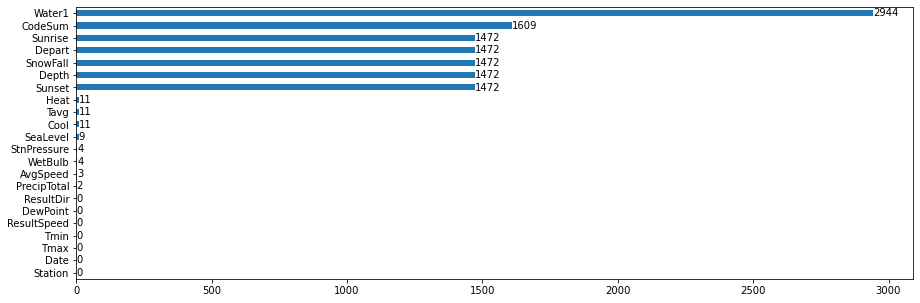

In [33]:
# plot bar chart of missing values

missing_data = weather.isnull().sum().sort_values(ascending=True)

missing_data.plot(kind='barh',figsize=(15,5))

for y, x in enumerate(missing_data):
    plt.annotate(str(x), xy=(x, y), va='center')

> **Interpretation:**
> * Water1 and CodeSum has the highest number of missing data. 
> * Sunrise, Sunset, Depart, SnowFall, Depth have the same number of missing data. 
> * We will tackle each feature with missing values as follows. 

In [34]:
#Dropping columns that has alot of missing values

weather.drop(['Depart','Depth','SnowFall','Water1','CodeSum'],axis=1, inplace=True)

In [35]:
# impute missing values using forward fill
weather[['Sunrise','Sunset','AvgSpeed']] = weather[['Sunrise','Sunset','AvgSpeed']].fillna(method='ffill')

In [36]:
# define function to return the average value between Min Temperature and Max Temperature

def temp_avg(row_index):
    
    average_temp = np.mean([weather.loc[row_index,'Tmax'],weather.loc[row_index,'Tmin']])
    return average_temp

# for loop to replace 
for i, row in weather.iterrows():
    if row['Tavg'] is None:
        row['Tavg'] = temp_avg(i)
    else:
        row['Tavg'] = row['Tavg']
    weather.at[i,'Tavg'] =row['Tavg']

In [37]:
# define function to return round values of float

def round_values(values):
    return round(float(values))

#Replacing missing value for SeaLevel with mean
weather['SeaLevel'] = pd.to_numeric(weather['SeaLevel'], errors='coerce')
weather['SeaLevel'].replace(np.nan, weather['SeaLevel'].mean(),inplace=True)
weather['SeaLevel'] = weather['SeaLevel'].map(round_values)
weather['SeaLevel']=weather.SeaLevel.astype(int)
# weather.SeaLevel.value_counts()

In [38]:
#Replacing missing value for Station Pressure with mean

weather['StnPressure'] = pd.to_numeric(weather['StnPressure'], errors='coerce')
weather['StnPressure'].replace(np.nan, weather['StnPressure'].mean(),inplace=True)
weather['StnPressure'] = weather['StnPressure'].map(round_values)
weather['StnPressure']=weather.StnPressure.astype(int)
#weather.StnPressure.value_counts()

In [39]:
#Filling Null values for WetBulb with Back fill as Station 1 contains the missing values. 
weather[['WetBulb']] = weather[['WetBulb']].fillna(method='bfill')

In [40]:
#Trace value indicates 0.01 
weather['PrecipTotal'] = weather['PrecipTotal'].replace(['  T'], '0.01')
weather['PrecipTotal'].replace('M', np.nan, inplace =True)
weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method='ffill')

In [41]:
#Filling null values for heat/cool

for i, row in weather.iterrows():
    if row['Heat'] is None:
        if int(row['Tavg']) >= 65:
            row['Cool'] = int(weather.loc[i,'Tavg']) - 65
            row['Heat'] = 0
        else:
            row['Heat']=  65 - int(weather.loc[i,'Tavg'])
            row['Cool'] = 0
    weather.at[i,'Heat'] =row['Heat']
    weather.at[i,'Cool'] =row['Cool']

In [42]:
#Convert the data type into integer

weather = weather.astype({'Tavg':'int64', 'Heat':'int64', 'Cool':'int64','WetBulb':'int64'})

## Merging train/test data with weather data

In [43]:
#Merge train with weather dataset

df_train_merged = train.merge(weather, on=['Date', 'Station'], how='left')
df_test_merged = test.merge(weather, on=['Date', 'Station'], how='left')

In [44]:
#parse date into year, month and day
def parsedate(df):
    df = df.copy()
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    return df   

df_train_merged = parsedate(df_train_merged)
spray = parsedate(spray)
df_test_merged = parsedate(df_test_merged)

In [45]:
# export merged files
# commenting this out as datasets have already been generated and stored in directory

#df_train_merged.to_csv('df_train.csv')
#df_test_merged.to_csv('df_test.csv')

# Key Insights from Exploratory Data Analysis

In [46]:
df_train = df_train_merged.copy()

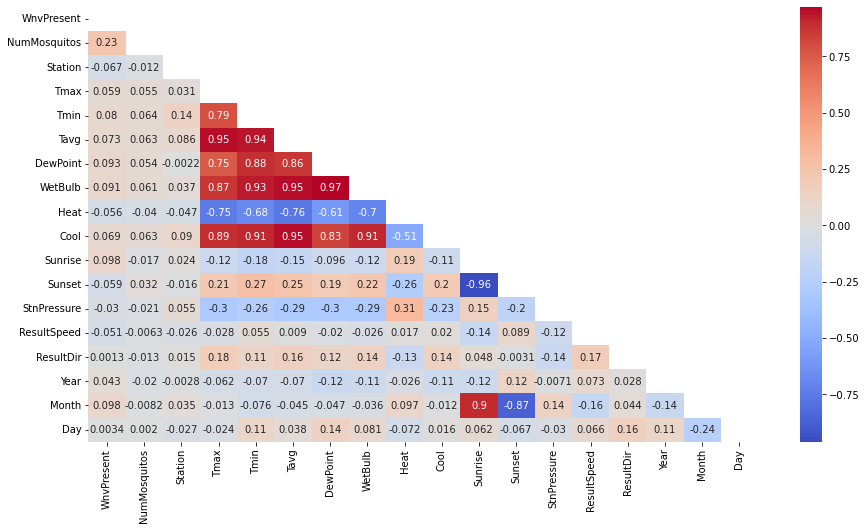

In [47]:
#Removing non-essential data for heatmap 

nonEss_train = df_train.drop(['Latitude','Longitude','SeaLevel'],axis=1)
mask = np.zeros_like(nonEss_train.corr())
mask[np.triu_indices_from(mask)] =True
plt.figure(figsize=(15,8))
sns.heatmap(nonEss_train.corr(),annot=True, cmap='coolwarm', mask=mask)
plt.show()

> **Interpretation:**
> * Correlation matrix highlights multicollinearity issue (>=0.95) in the merged datasets:
>  * Tavg/Tmin/Tmax
>  * WetBulb/DewPoint
>  * Cool/Tavg
> * We will discard either one feature in each set just before modelling.

Text(0, 0.5, 'Number of mosquitos')

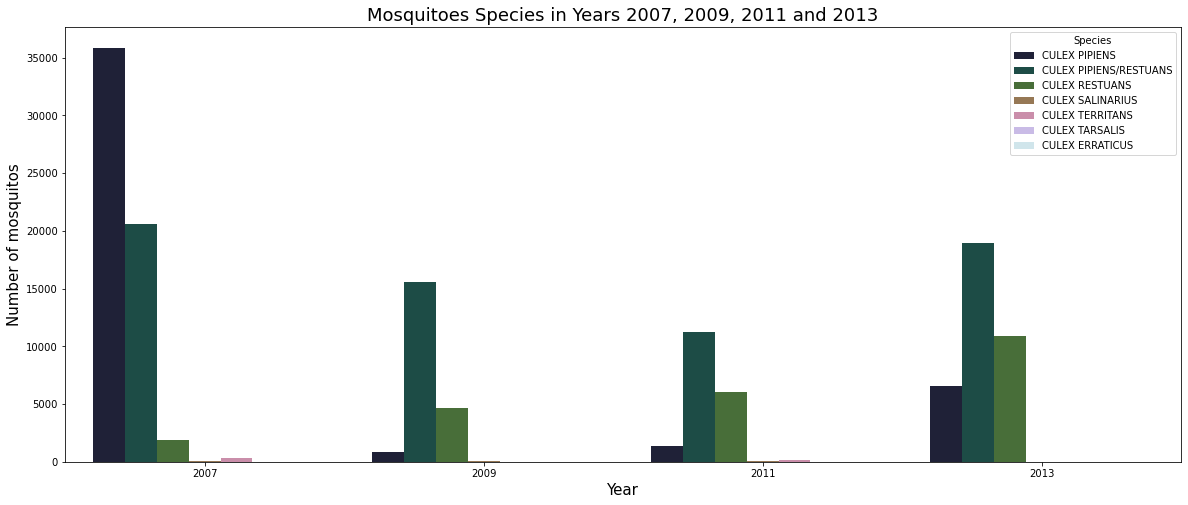

In [48]:
#Number of mosquitos per year and per species
mosquitoes_years = df_train.groupby(['Year','Species'], as_index=False).sum().reindex()

plt.figure(figsize=(20,8))
sns.barplot(x='Year',y='NumMosquitos',hue='Species',data= mosquitoes_years,palette='cubehelix')
plt.title('Mosquitoes Species in Years 2007, 2009, 2011 and 2013',fontsize=18)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of mosquitos', fontsize=15)

> **Interpretation:**
> * Across all four years, two mosquito species formed the majority of mosquitos caught each year. These species are: culex pipiens and culex restuans. 
> * The frequencies of other mosquito species are low or almost negligible.

Text(0, 0.5, 'Count')

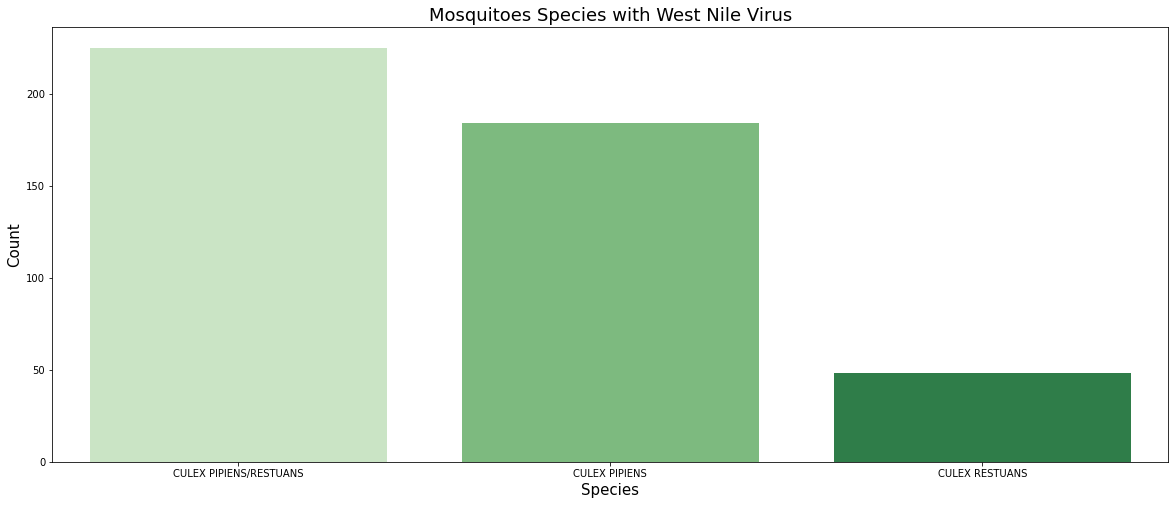

In [49]:
# It is noted that not all mosquito species carry the virus 
# to sort species that have the virus only
wnv_mosquitos = df_train.loc[df_train['WnvPresent'] == 1,['Species']]

plt.figure(figsize=(20,8))
sns.countplot(x = 'Species',data = wnv_mosquitos,palette='Greens')
plt.title('Mosquitoes Species with West Nile Virus',fontsize=18)
plt.xlabel('Species', fontsize=15)
plt.ylabel('Count', fontsize=15)

> **Interpretation:**
> * Across all four years in the train dataset, culex pipiens and culex restuans species are identified to be carriers of the West Nile Virus. 

Text(0, 0.5, 'Count')

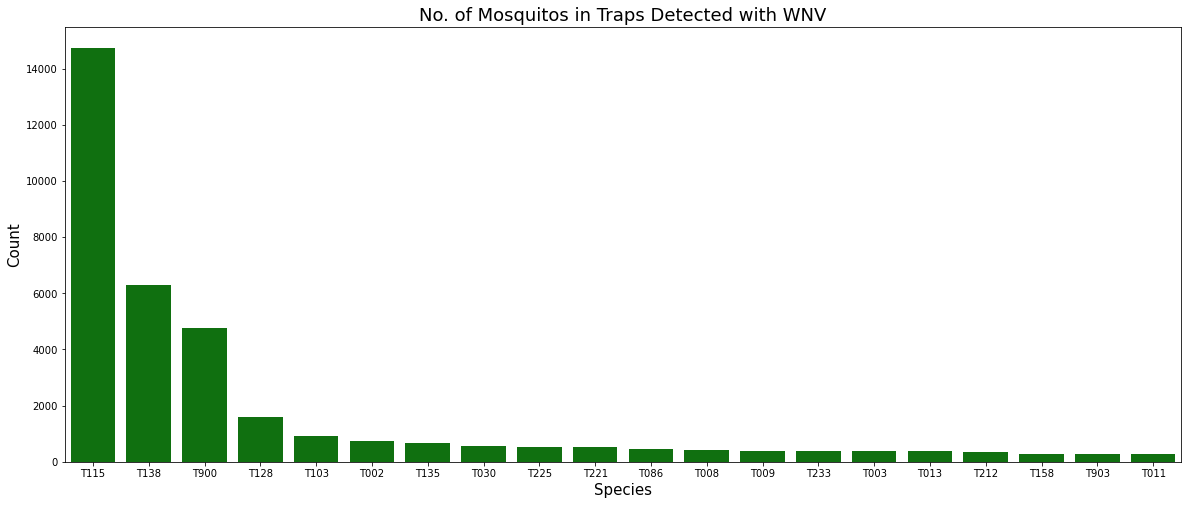

In [50]:
# to group same traps together and count how many mosquitoes were caught

trap_mosquitos = df_train.groupby(['Trap','WnvPresent'], as_index=False).sum().reindex()
trap_mosquitos = trap_mosquitos[trap_mosquitos['WnvPresent'] == 1]
trap_mosquitos_top20 = trap_mosquitos.sort_values(by='NumMosquitos',ascending=False).head(20)

plt.figure(figsize=(20,8))
sns.barplot(x = 'Trap',y='NumMosquitos',data = trap_mosquitos_top20,color='Green')
plt.title('No. of Mosquitos in Traps Detected with WNV',fontsize=18)
plt.xlabel('Species', fontsize=15)
plt.ylabel('Count', fontsize=15)

> **Interpretation:**
> 
> * Trap T115 captured the highest number of mosquitos. 
> * However, when we compare with the traps that highest occurrence of virus detected, it shows that higher no. of mosquitos caught does not always mean higher occurrence of virus detected. 
> * In fact, trap T900 (third highest no. of mosquitos) is the one with the highest occurrence of virus detected.

<AxesSubplot:title={'center':'Traps with highest occurrence of WNV detected'}>

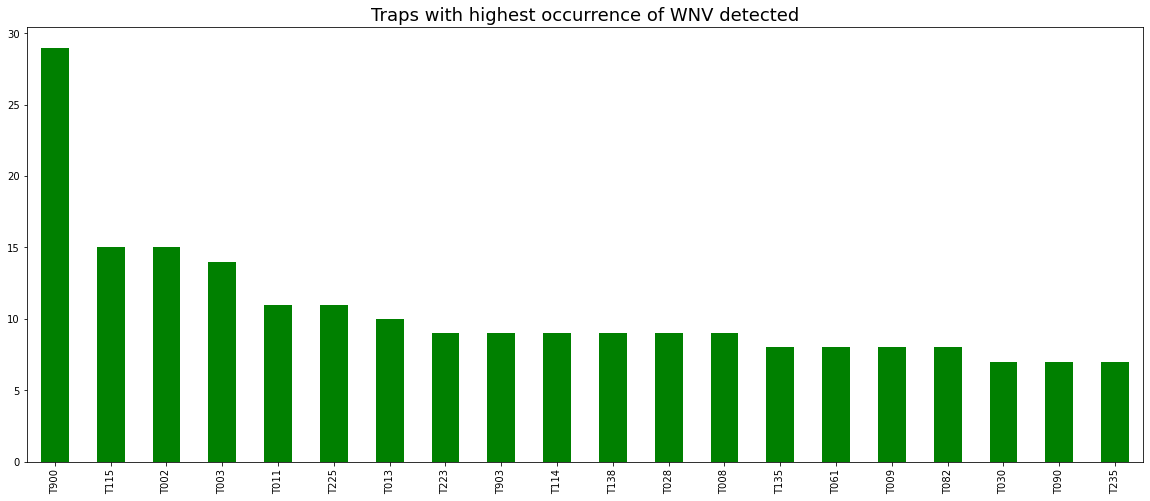

In [51]:
# plot a chart to show which traps have caught virus-carrying mosquitos across unique days

plt.figure(figsize=(20, 8))
plt.title("Traps with highest occurrence of WNV detected",fontsize=18)
df_train['Trap'][df_train['WnvPresent'] == 1].value_counts(ascending=False).head(20).plot(kind="bar",color='green')

> **Interpretation:**
>
> * The top four traps with highest occurrence of virus detected are located in:
>   1. ORD Terminal 5, O'Hare International Airport, Chicago, IL
>   2. South Doty Avenue, Chicago, IL
>   3. 4100 North Oak Park Avenue, Chicago, IL
>   4. 4600 Milwaukee Avenue, Chicago, IL

In [52]:
train_c[(train_c['Trap'] == 'T900') | (train_c['Trap'] == 'T115') | (train_c['Trap'] == 'T002') | (train_c['Trap'] == 'T003')]['Address'].unique()

array(['4100 North Oak Park Avenue, Chicago, IL 60634, USA',
       '4600 Milwaukee Avenue, Chicago, IL 60630, USA',
       'South Doty Avenue, Chicago, IL, USA',
       "ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA"],
      dtype=object)

## Comparing locations of sprays and virus detected in 2011 and 2013

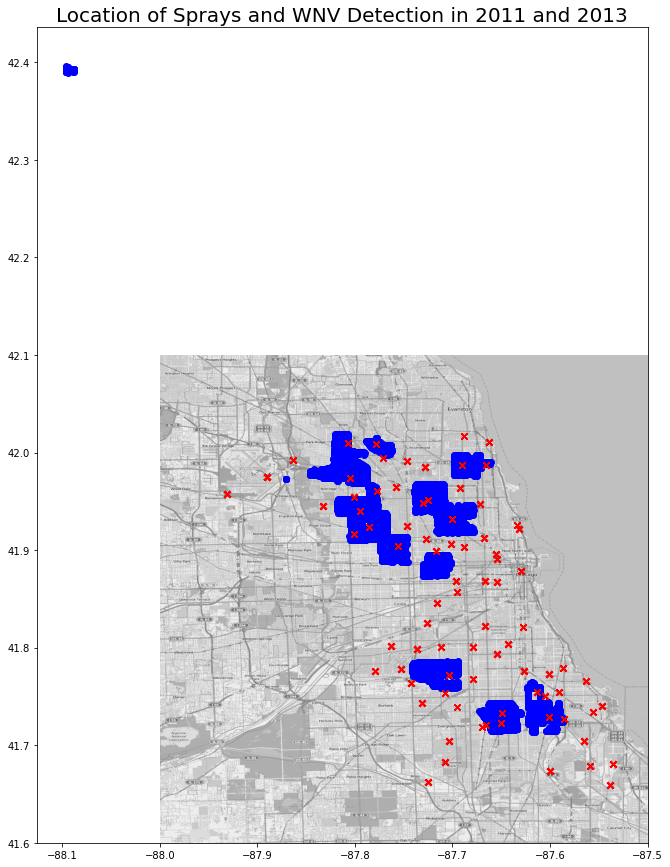

In [53]:
# define temporary dataframe for years 2011 and 2013

temp = df_train[(df_train['Year'] == 2011) | (df_train['Year'] == 2013)]

# define plot space

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")

# generate plot

plt.figure(figsize=(15,15))
plt.title('Location of Sprays and WNV Detection in 2011 and 2013',fontsize=20)
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=[origin[1], upperRight[1], origin[0], upperRight[0]]);

plt.scatter(spray['Longitude'], spray['Latitude'], c='blue', alpha=1)
plt.scatter(temp['Longitude'], temp['Latitude'], marker='x', c = 'r', label='Trap')

> **Interpretation:**
> * The points cross in red are the locations detected with the virus while the areas highlighted in blue were sprayed with the pesticide. 
> * In 2011 and 2013, the areas sprayed with the pesticide to kill the mosquitos did not completely cover the areas where the virus were detected. Quite a lot of areas were missed out. 
> * However, it is noted that the spray dataset is incomplete. Therefore, this plot is a poor representation of the actual situation. 

In [54]:
# create a temporary dataframe for WnvPresent == 1, with count of occurrences per trap

tmp = df_train[df_train['WnvPresent'] == 1][['Trap','Latitude','Longitude','Year']]
tmp['counts'] = tmp['Trap'].map(tmp['Trap'].value_counts())
tmp = tmp.drop_duplicates(subset=['Trap','Latitude','Longitude','Year','counts'])

# plot a scatterplot on a map with the color red signifying areas detected with virus and size indicated frequency of virus detected

fig = px.scatter_mapbox(tmp, lat=tmp['Latitude'], lon=tmp['Longitude'],
                         zoom = 8, size = tmp['counts'],
                        animation_frame='Year',
                        title = 'Presence of West Nile Virus in Chicago',
                        color_discrete_sequence=["red"]
                       )

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":10})

fig.show()

#fig.write_html("map1.html")

> **Interpretation:**
> * Each bubble in red denotes the location of the traps where the virus is detected, and the size of the bubble indicates the frequency of virus detected. 

Text(0, 0.5, 'Number of Mosquitos')

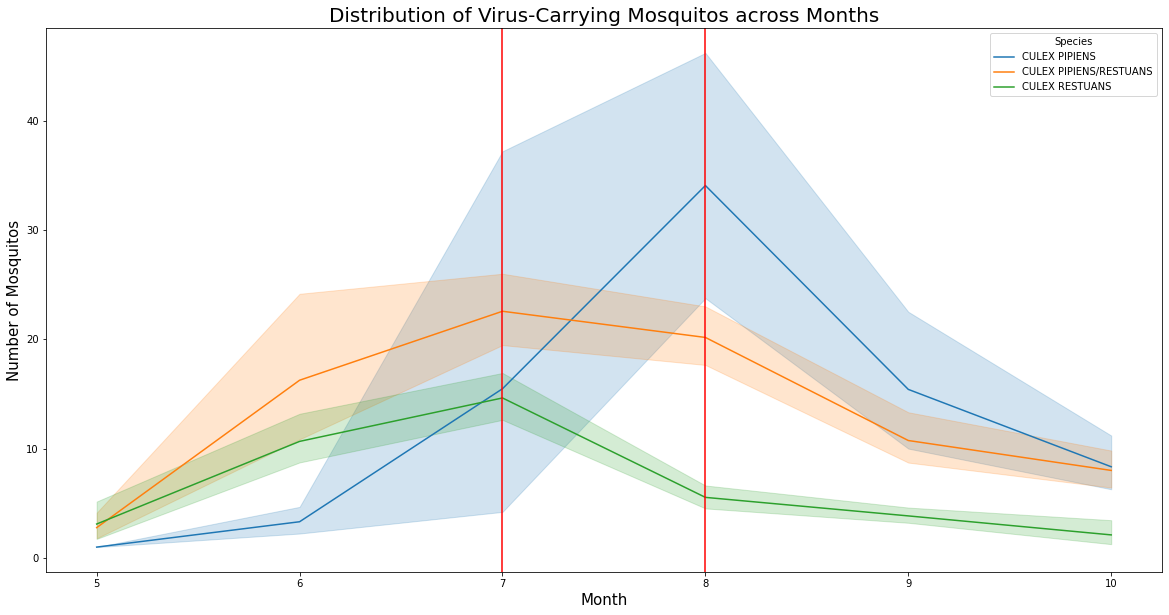

In [55]:
# show only the three species that cause the virus 

fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='Month',y='NumMosquitos',hue='Species',data=df_train[df_train['Species'].isin(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS'])])
plt.axvline(7,c='r')
plt.axvline(8,c='r')
plt.title('Distribution of Virus-Carrying Mosquitos across Months',fontsize=20)
plt.xlabel('Month',size=15)
plt.ylabel('Number of Mosquitos',size=15)

> **Interpretation:**
> * The presence of the West Nile virus is certainly detected beyond a threshold of 1600 mosquitos captured in a trap at any given time. 

Text(0, 0.5, 'Number of Mosquitos')

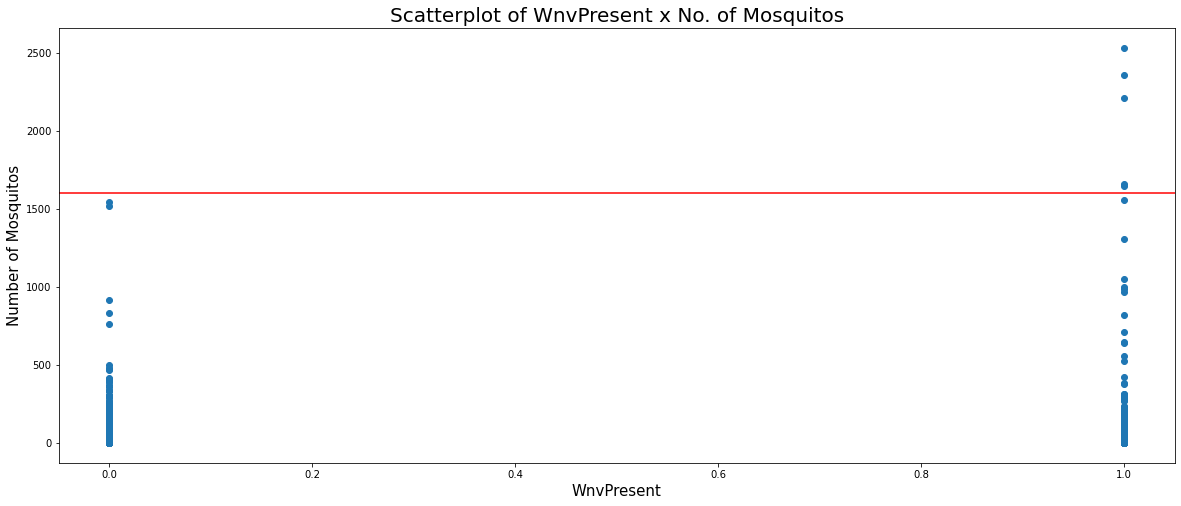

In [56]:
# scatterplot between presence of virus and number of mosquitoes
# >1500 mosquitoes captured in trap tend to have virus

fig, ax = plt.subplots(figsize=(20,8))
plt.scatter(x='WnvPresent',y='NumMosquitos',data=df_train)
plt.axhline(y=1600,c='r')
plt.title('Scatterplot of WnvPresent x No. of Mosquitos',size=20)
plt.xlabel('WnvPresent',size=15)
plt.ylabel('Number of Mosquitos',size=15)

> **Interpretation:**
> * The presence of the West Nile virus is certainly detected beyond a threshold of 1600 mosquitos captured in a trap at any given time. 

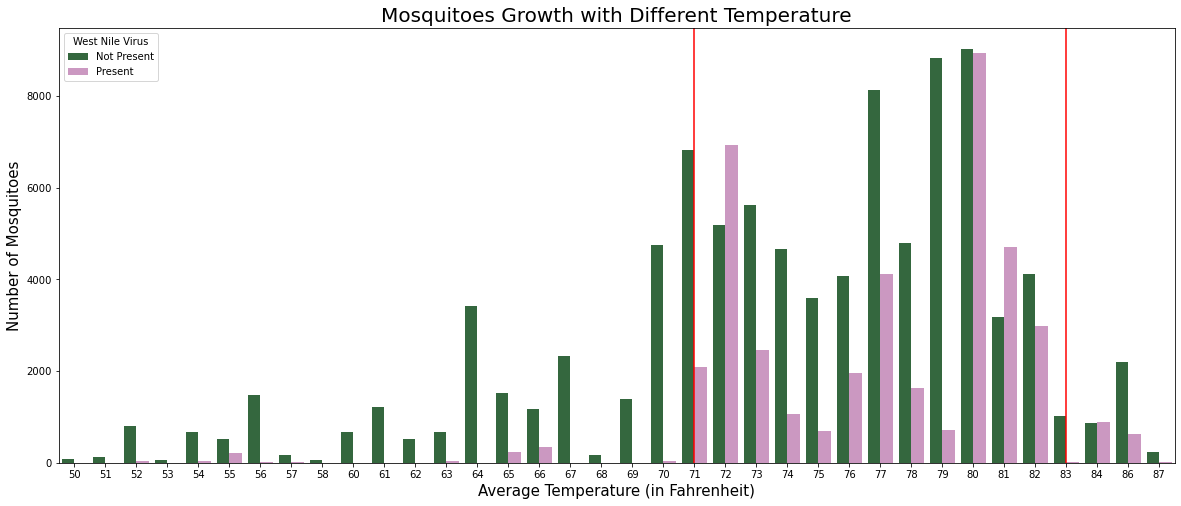

In [57]:
#Number of mosquitos vs temp
mosquitos_temp = df_train_merged.groupby(['Tavg','WnvPresent'],as_index=False).sum().reindex()

fig,ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Tavg', y='NumMosquitos', hue='WnvPresent',data=mosquitos_temp, palette='cubehelix')
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=2,handles=hands,title= 'West Nile Virus',labels = ['Not Present','Present'])
plt.title('Mosquitoes Growth with Different Temperature',fontsize=20)
plt.xlabel('Average Temperature (in Fahrenheit)',fontsize=15)
plt.ylabel('Number of Mosquitoes',fontsize=15)
plt.axvline(x=32,color='red')
plt.axvline(x=20,color='red')
plt.show()

> **Interpretation:**
> 1. The ideal temperature for mosquito growth is between 71 to 83 Fahrenheit (21 - 28.3 Celsius) 
> 2. There is no indication of any specific temperature would harvest higher count of mosquitoes with West nile virus. Generally higher mosquitoes counts would increase the probabilities of west nile virus detected (only applicable to specific species - culex pipiens, culex pipens/restuans, culex restuans) 
> 3. We can focus our efforts of spray whenever the station temperature hits the range as the mosquitoes are more active and limits the spray effort for temperature below/over the the range. This will help us reduce cost and maximising the impact. 


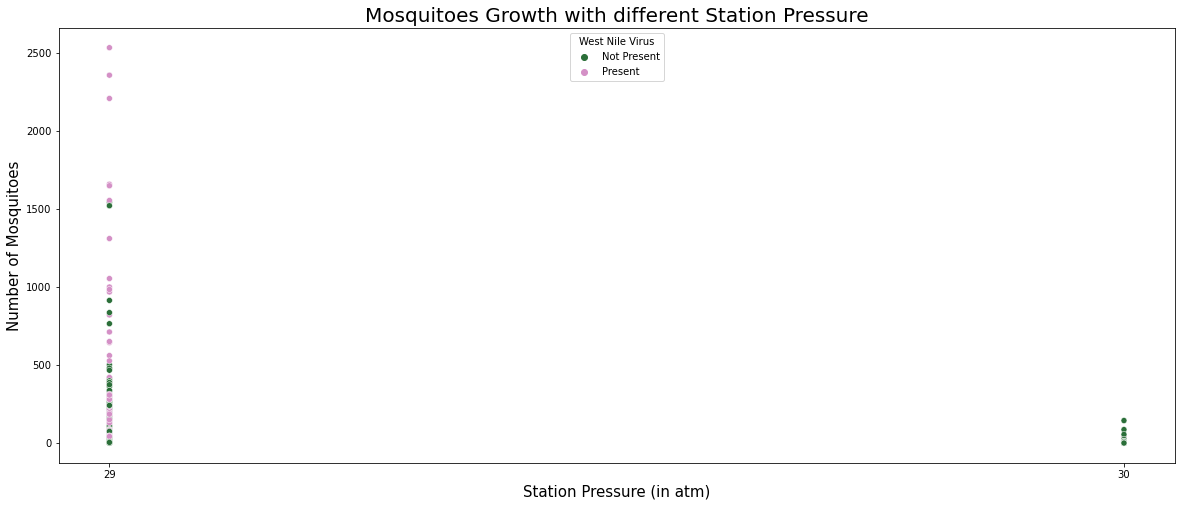

In [58]:
#Station Pressure and Mosquitoes growth

fig , ax = plt.subplots(figsize=(20,8))
sns.scatterplot(x='StnPressure', y='NumMosquitos', hue='WnvPresent',data=df_train_merged, palette='cubehelix')
plt.title('Mosquitoes Growth with different Station Pressure',fontsize=20)
plt.xlabel('Station Pressure (in atm)',fontsize=15)
plt.ylabel('Number of Mosquitoes',fontsize=15)
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=9,handles=hands,title= 'West Nile Virus',labels = ['Not Present','Present'])
plt.xticks(ticks=[29,30])

plt.show()

> **Interpretations:**
> 1. Generally the station pressure measures the pressure exerted by the atmosphere at a point as a result of gravity acting upon the column of air that lies directly above the point. As we look at the chart, we can see that most of the mosquitoes are caught with station pressure around 29. 
> 2. On top of the large amount of mosquitoes caught, all the west nile virus mosquitoes are detected with station pressure around 29 as compared to station pressure 30. 
> 3. Although the difference between the station pressure is merely 1 but the impact on mosquitoes caught seems to have a significant impact as there is a large discrepency in the result findings.
> 4. A live station pressure update would help in aiding the efforts and impact of spray whenever the station pressure is within 29 range as well as other indicators found (temperature range, Dewpoint etc).
>
> Note: ATM refers to Atmospheres pressure in units of measurement


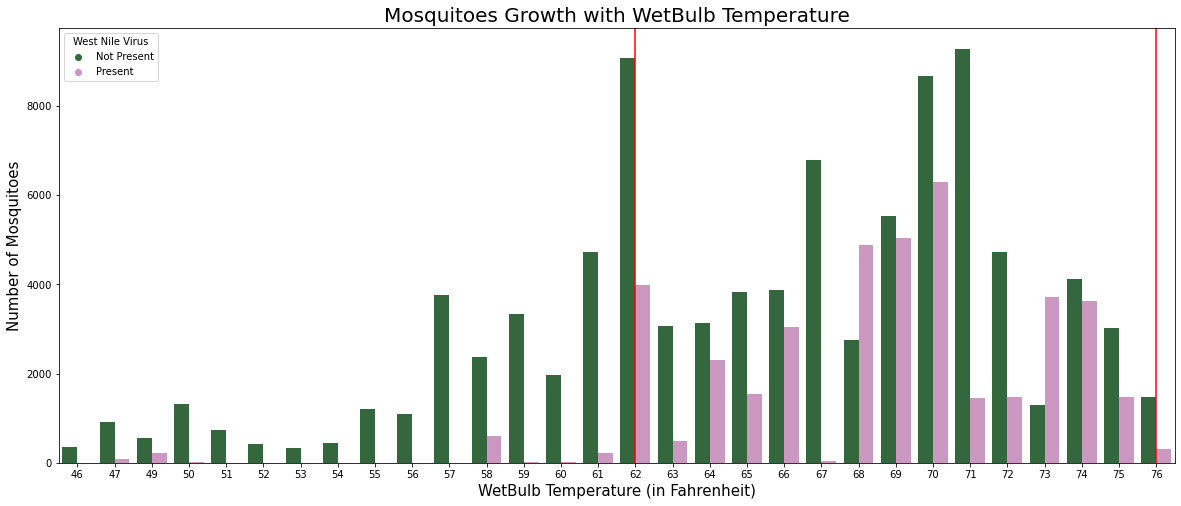

In [59]:
#Number of mosquitos vs WetBulb
mosquitos_temp = df_train_merged.groupby(['WetBulb','WnvPresent'],as_index=False).sum().reindex()
plt.figure(figsize=(20,8))

sns.barplot(x='WetBulb', y='NumMosquitos', hue='WnvPresent',data=mosquitos_temp, palette='cubehelix')
plt.title('Mosquitoes Growth with WetBulb Temperature',fontsize=20)
plt.xlabel('WetBulb Temperature (in Fahrenheit)',fontsize=15)
plt.ylabel('Number of Mosquitoes',fontsize=15)
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=2,handles=hands,title= 'West Nile Virus',labels = ['Not Present','Present'])
plt.axvline(x=29,color='red')
plt.axvline(x=15,color='red')
plt.show()

#long jump could be due to median used (Skewed data, need to relook)
#The drier and less humid the air is, the faster the water will evaporate. The faster water evaporates, the lower the thermometer's temperature will be relative to air temperature.

> **Intepretation:**
> 1. The Wetbulb temperature is simply the cooling effect of temperature with moisture air content. If the moisture content of air is high, it will lose lesser heat to the air and wetbulb temperature will be higher. As we look at the chart, we can see that wetbulb temperature of 62 fahrenheit (16.6 celsius) onwards would lead to a huge growth in mosquito breeding as well as WNV. 


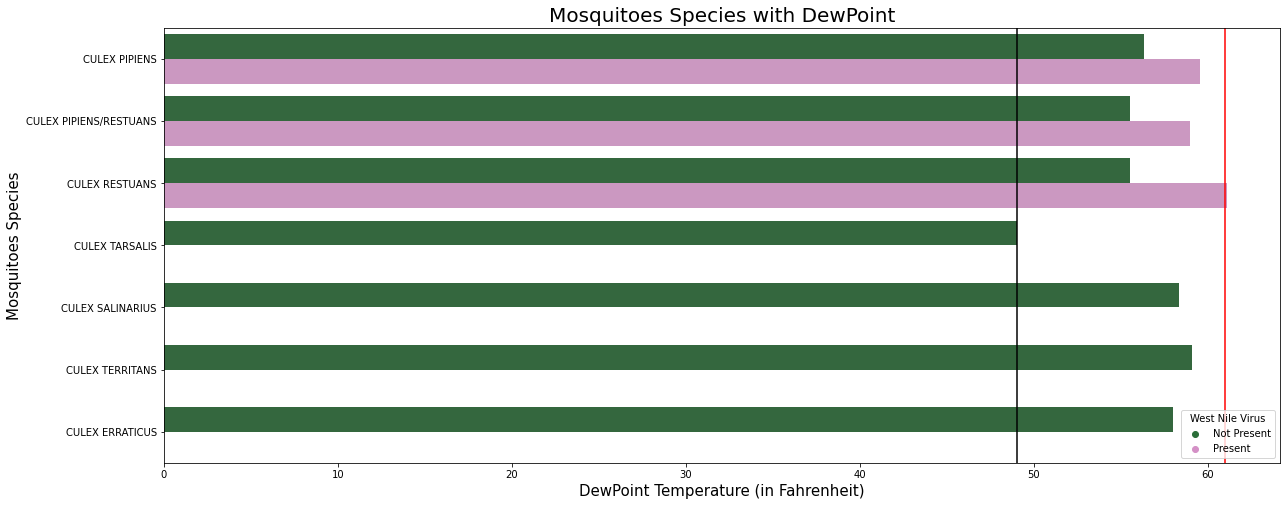

In [60]:
#Number of Mosquitos Species vs dewpoint
mosquitos_temp = df_train_merged.groupby(['DewPoint','Species','WnvPresent'],as_index=False).sum().reindex()
plt.figure(figsize=(20,8))

sns.barplot(x='DewPoint', y='Species',hue='WnvPresent',data=mosquitos_temp, palette='cubehelix',ci=None)
plt.title('Mosquitoes Species with DewPoint',fontsize=20)
plt.xlabel('DewPoint Temperature (in Fahrenheit)',fontsize=15)
plt.ylabel('Mosquitoes Species',fontsize=15)
plt.axvline(x=61,color='red')
plt.axvline(x=49,color='black')
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=4,handles=hands,title= 'West Nile Virus',labels =['Not Present','Present'])
plt.show()


> **Interpretation:**
> 1. As mentioned earlier in the train data set, not all mosquito species can carry the West Nile virus. For the 3 main types of we can see that mosquitoes carrying the west nile virus generally thrives at around 56-61 fahrenheit (14.44 - 15.5 celsius)
> 2. Generally if our priority is to eliminate mosquitoes, we can always implement sprays on areas with high mosquito counts whenever dewpoint hits within 49 - 61 fahrenheit. If mosquitoes species such as Culex Tarsalis is not our priority, we can always deploy sprays whenever dewpoint is higher around 56-61 fahrenheit (14.44 - 15.5 celsius). This flexibility is useful especially when we have limited resources. 

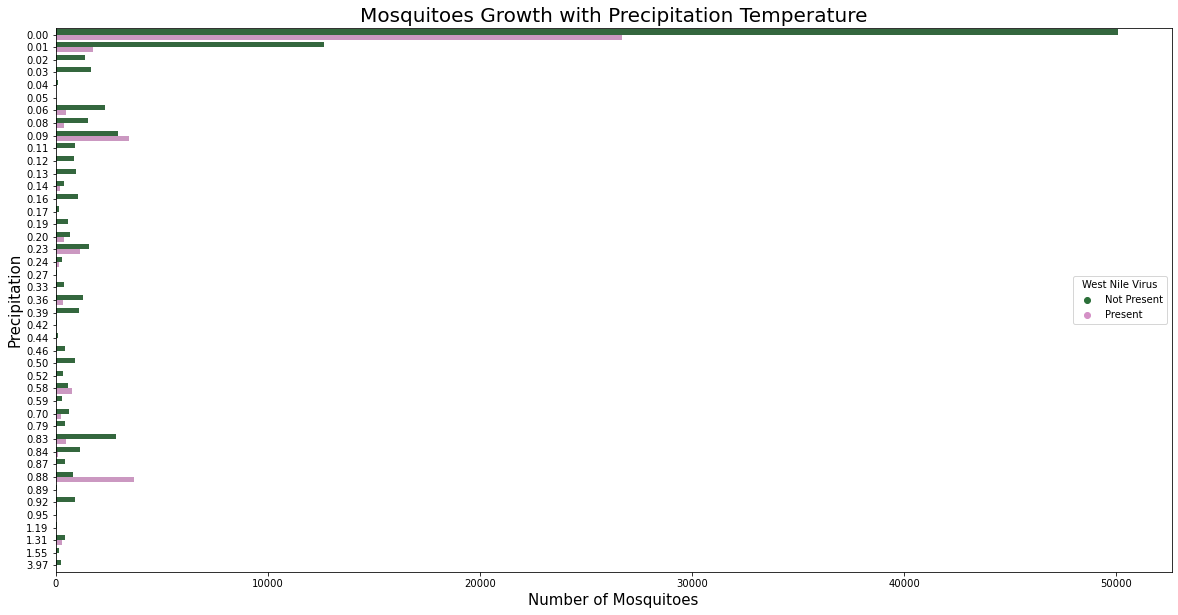

In [61]:
#Plotting number of Mosquitoes vs Precipitation

mosquitos_temp = df_train_merged.groupby(['PrecipTotal','WnvPresent'],as_index=False)['NumMosquitos'].agg(sum)
plt.figure(figsize=(20,10))

sns.barplot(x='NumMosquitos', y='PrecipTotal',hue='WnvPresent',data=mosquitos_temp, palette='cubehelix', orient = 'h')
plt.title('Mosquitoes Growth with Precipitation Temperature',fontsize=20)
plt.xlabel('Number of Mosquitoes',fontsize=15)
plt.ylabel('Precipitation',fontsize=15)
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=5,handles=hands,title= 'West Nile Virus',labels = ['Not Present','Present'])

plt.show()


> **Interpretation:**
> 1. Precipation is simply the quantity of water deposit in the atmosphere. As we can see in the charts, Mosquitoes generally thrives in precipitation ranging between 0.00 to 0.01. This also applies to mosquitoes carrying the west nile virus as well. 
> 2. As we can see with higher precipitation, such as during rainy days of snowing periods, mosquitoes does not do very well . This coincides with our previous charts measuring the various temperatures above. 
> 3. For days with low precipations, we can consider spraying more oftens on affected locations to effectively eliminate mosquito breeding whenever it hits between 0.00 and 0.01. 
> 4. For high precipations periods, we will continue the spray less extensively as mosquitoes do still continue to grow but at a very small pace. This will allow us to conserve and deploy the resources better to fight against the west nile virus. 


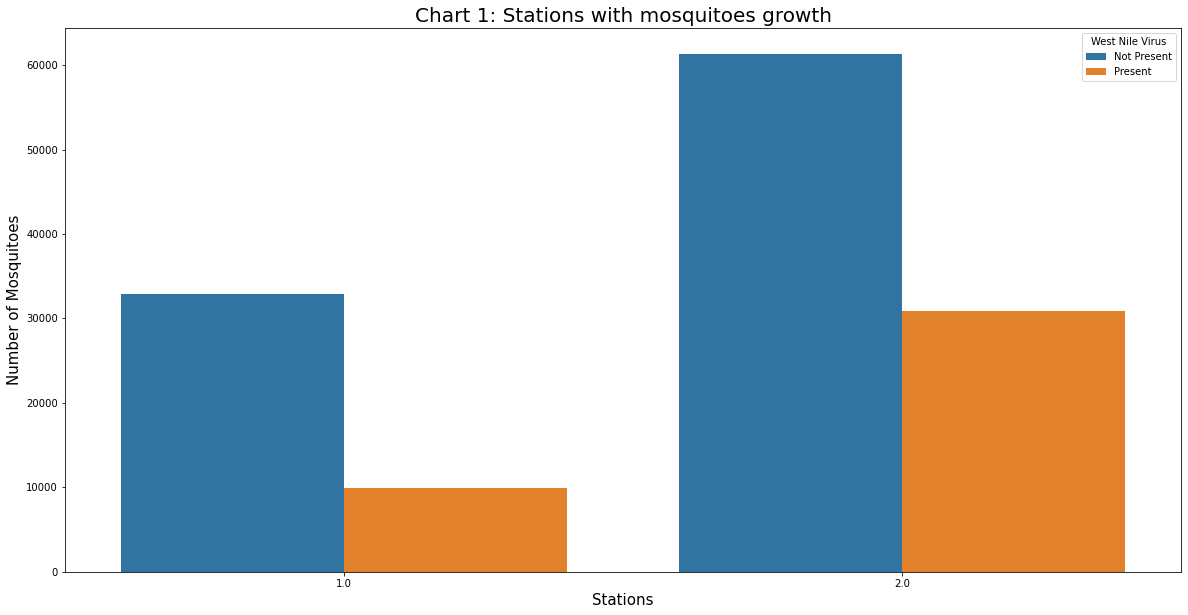

In [62]:
#Stations vs mosq count (Chart 1)
mosquitos_temp = df_train_merged.groupby(['Station','WnvPresent'],as_index=False)['NumMosquitos'].agg('sum')
fig , ax = plt.subplots(figsize=(20,10))

sns.barplot(x='Station', y='NumMosquitos', hue='WnvPresent',data=mosquitos_temp)
plt.title('Chart 1: Stations with mosquitoes growth',fontsize=20)
plt.xlabel('Stations',fontsize=15)
plt.ylabel('Number of Mosquitoes',fontsize=15)
hands, labs = ax.get_legend_handles_labels()
plt.legend(loc=0,handles=hands,title= 'West Nile Virus',labels = ['Not Present','Present'])
plt.show()


> **Interpretation:** 
> ##### Chart 1
> 1. For Chart 1, we can clearly see that station 2 has a higher count of mosquitoes as well as West nile virus as compared to station 1. As the difference is almost doubled (Triple for west nile virus), this indicates that we need to allocate more resources to station 2 as compared to station 1 to control the mosquito breeding. 

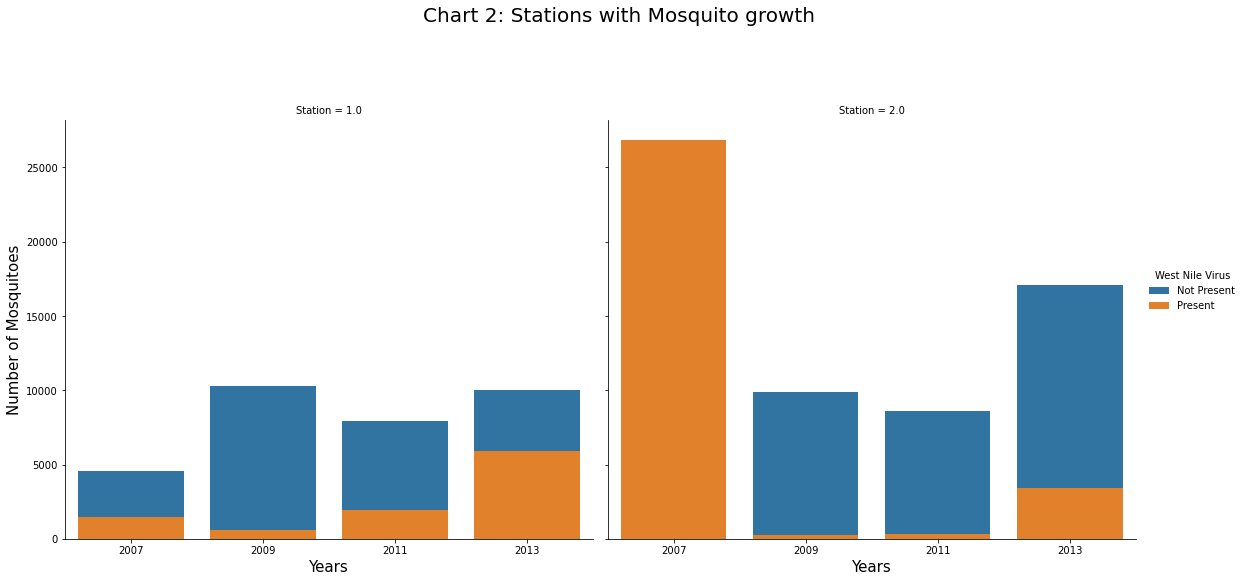

In [63]:
#Stations VS Mosquitoes Count (Chart 2)
sorted_dataframe = df_train_merged.groupby(['Year','Station','WnvPresent'], as_index=False)['NumMosquitos'].agg('sum')
g = sns.FacetGrid(sorted_dataframe, col='Station', hue='WnvPresent',size=8)

g.map(sns.barplot, 'Year', 'NumMosquitos')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Chart 2: Stations with Mosquito growth', va='center',fontsize=20)
g.set_axis_labels(x_var='Years', y_var='Number of Mosquitoes',fontsize=15)
g.add_legend(title= 'West Nile Virus',handles = hands, labels = ['Not Present','Present'])
plt.show()

> **Interpretation:** 
>
> ##### Chart 2
> 2. We investigated further by including the years across both stations displayed in chart 2 and realised that a large count of mosquitoes were caught in 2007, there were a total of 26,865 mosquitoes that were deemed to have West Nile virus(WNV) Present while 25,741 mosquitoes deemed without WNV for station 2. 
>    - A point to note here is that while not all 26,865 mosquitoes caught were infected by WNV. As each trap count has a cap of 50 mosquitoes, there were groups of mosquitoes within the same trap that did not contain the WNV. However as we are detecting if WNV present or not at a specific location instead of how many mosquitoes are infected, we simply assumed mosquitoes caught by the same trap, at the same location with the same species to be classified as WNV present as the WNV can spread among similar species within the same location/trap. 
> 3. While the effect of the spray might have contributed to the decline in mosquito breeding in station 2 for year 2009 and 2011, we can see that there is an increase in mosquito breeding in 2013 with WNV infected mosquitoes increasing as well. This indicates that we need to increase our resources and efforts to tackle the uptrend before it catches up to 2007 high. 
> 4. As we look at station 1 on the left for chart 2, we can see the count of mosquitoes are relatively contained, however there is an increase in mosquitoes infected with WNV as we can see a uptrend from 2009 to 2013. This indicates that although the count is low, we still need to continue our efforts on the spray on station 1 to control/eliminate the spread. 

